In [230]:
import os
print(os.getcwd())

C:\Users\Biswadeep


In [231]:
def generateLists(folder):

    AST_labels = []

    for f in os.listdir(folder):
        AST_labels.append(str(f))            
    return AST_labels

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import re

In [233]:
mape_threshold = 4

In [234]:
folder = r"C:\Users\Biswadeep\Documents\ECM\ECM"
currents = [100,500,1000]
circuit = "L0-R0-p(R1,C1)-p(R2,C2-G2)"

matrix_input = []
rmse = []
mape = []

import pickle 

for current in currents:
    file = f"C:\\Users\\Biswadeep\\Documents\\ECM\\ECM\\RH100,{current}\\analytics.pkl"
    
    data = None
    with open(file, "rb") as f:
        data = pickle.load(f)

    circuit_dict = data["circuit_dict"] 
    DRT_dict = data["DRT_dict"]
    invalid_model = data["invalid_model"]

    start = 1
    end = 34
    for cell in range(start,end+1):
        if 3<cell<10:
            continue  #skipping these cells for now 
        f = f"Cell_{cell:02}"  # Pads i to two digits
        #folder = f"C:\\Users\\praktikant\\Desktop\\Dataset\\01-Data\\{f}\\04-EIS_H2Air_RH100\\1000mAcm2"
        folder = f"D:\\Dataset\\01-Data\\{f}\\04-EIS_H2Air_RH100\\{current}mAcm2"

        if not os.path.exists(folder):
            continue
        AST_labels = generateLists(folder)

        for j in AST_labels:
            key1 = f
            key2 = f'AST {j}'
            key = (key1,key2,circuit)
            numbers = re.findall(r'\d+', key2)
            cycle_num = [int(num) for num in numbers][0] #there is only a single number here            
            if key in circuit_dict:
                L0, R0, R1, C1, R2, C2, RG2, tau2 = circuit_dict[key][1].parameters_
                if R1>R2:
                    R1,R2 = R2,R1 #swapping the resistances to ensure cathode resistance is higher
                row = [cell, cycle_num, L0, R0, R1, C1, C2, RG2, tau2, current, R2] 
                matrix_input.append(row)
                rmse_val = circuit_dict[key][2]
                mape_val = circuit_dict[key][3]
                if mape_val > mape_threshold:
                    print(f"Cell involved: {key}\t Current density: {current}\t Mape Error: {mape_val:.2f}%") #let us see if we have any better models for this cell
                rmse.append(rmse_val)
                mape.append(mape_val)
            
X = np.vstack(matrix_input)

print(X.shape)
        


Cell involved: ('Cell_10', 'AST 5000cycles', 'L0-R0-p(R1,C1)-p(R2,C2-G2)')	 Current density: 100	 Mape Error: 9.06%
Cell involved: ('Cell_13', 'AST 10000cycles', 'L0-R0-p(R1,C1)-p(R2,C2-G2)')	 Current density: 500	 Mape Error: 6.15%
Cell involved: ('Cell_17', 'AST 1000cycles', 'L0-R0-p(R1,C1)-p(R2,C2-G2)')	 Current density: 500	 Mape Error: 6.05%
Cell involved: ('Cell_19', 'AST 30000cycles', 'L0-R0-p(R1,C1)-p(R2,C2-G2)')	 Current density: 1000	 Mape Error: 6.31%
Cell involved: ('Cell_20', 'AST 30000cycles', 'L0-R0-p(R1,C1)-p(R2,C2-G2)')	 Current density: 1000	 Mape Error: 4.52%
(417, 11)


In [235]:
columns = ['Cell','Cycle','L0', 'R0', 'R1', 'C1', 'C2', 'RG2', 'tau2','Current', 'R2']
input_df = pd.DataFrame(X, columns=columns)

In [236]:
target_currents = [100,500,100]

In [237]:
def plot_R2(input_df,start,end,current):
    
    filtered_df = input_df[input_df['Current'] == current]
    filtered_df = filtered_df.sort_values(by=['Cell','Cycle'])

    plt.figure(figsize = (12,6))

    for cell in filtered_df['Cell'].unique():
        if cell<start or cell>end:
            continue
        cell_data = filtered_df[filtered_df['Cell'] == cell]
        plt.plot(cell_data['Cycle'],cell_data['R2'],label = f'Cell {int(cell)}')
    plt.xlabel('Cycle number')
    plt.ylabel('Cathode Rct')
    plt.title(f'Evolution of R2 across cycles at j = {int(current)}mA/cm^2')
    plt.legend(title='Cell',bbox_to_anchor=(1.05,1),loc='upper left')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

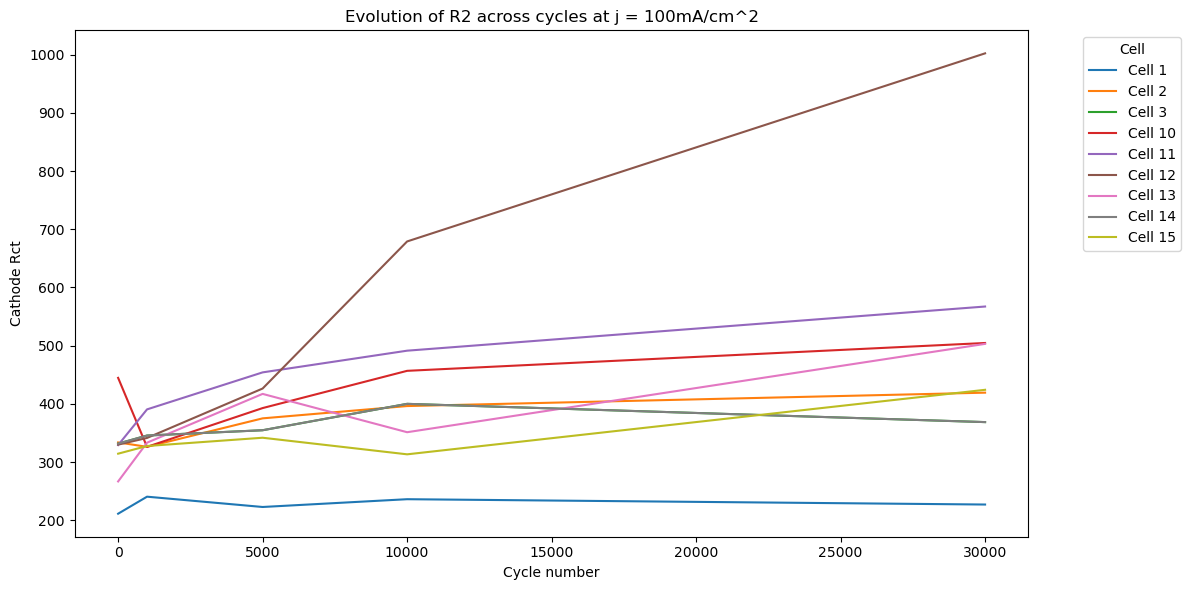

In [238]:
plot_R2(input_df,1,15,100)

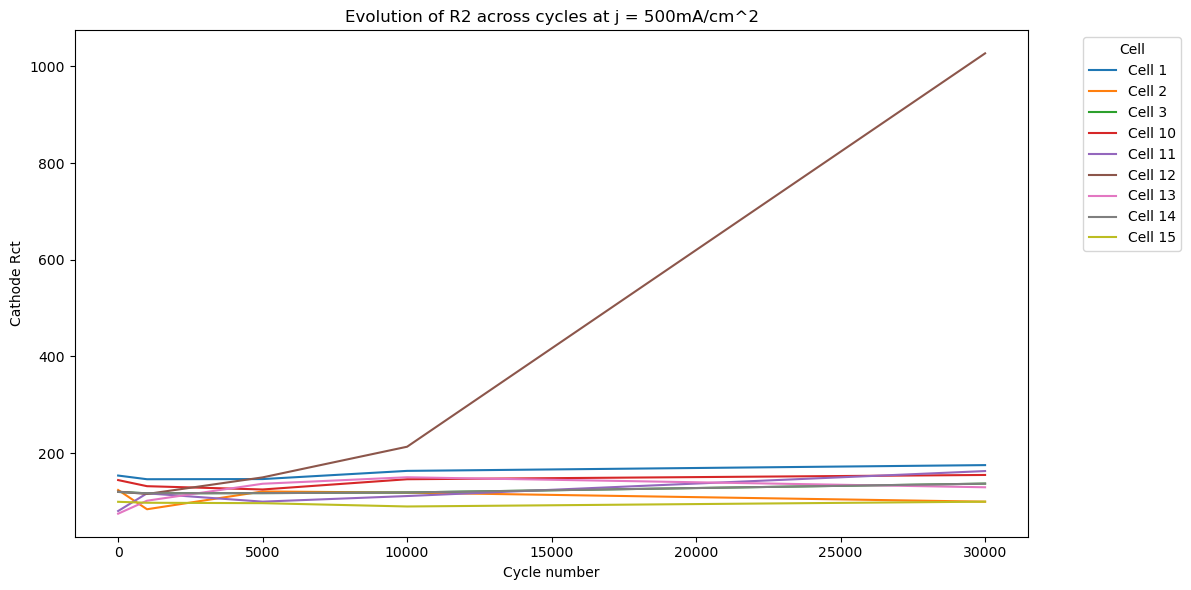

In [239]:
plot_R2(input_df,1,15,500)

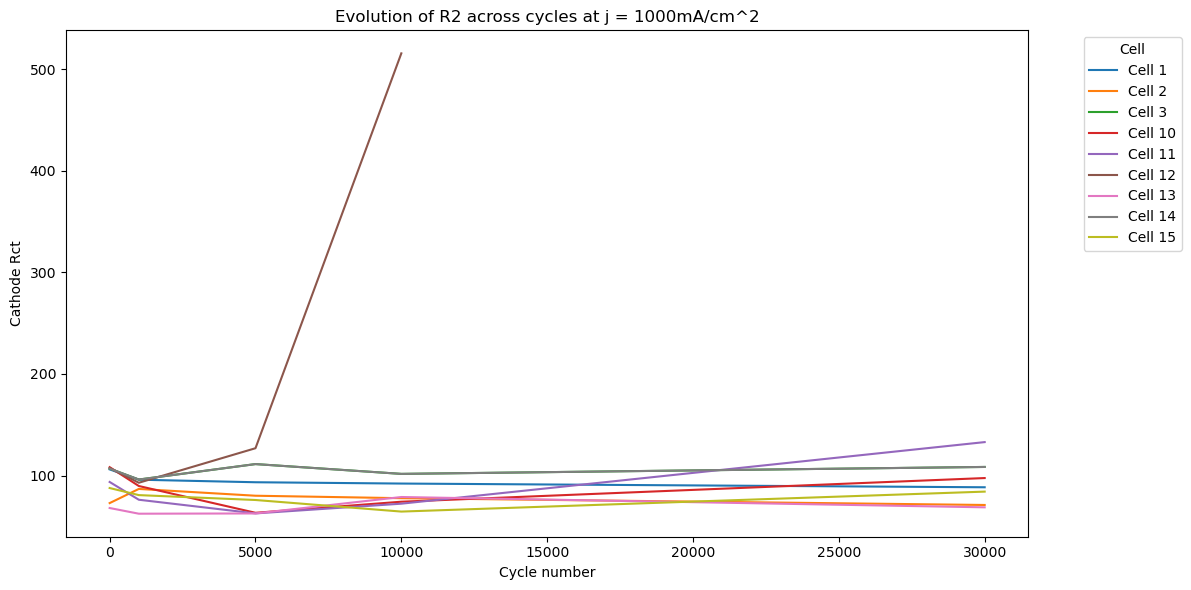

In [240]:
plot_R2(input_df,1,15,1000)

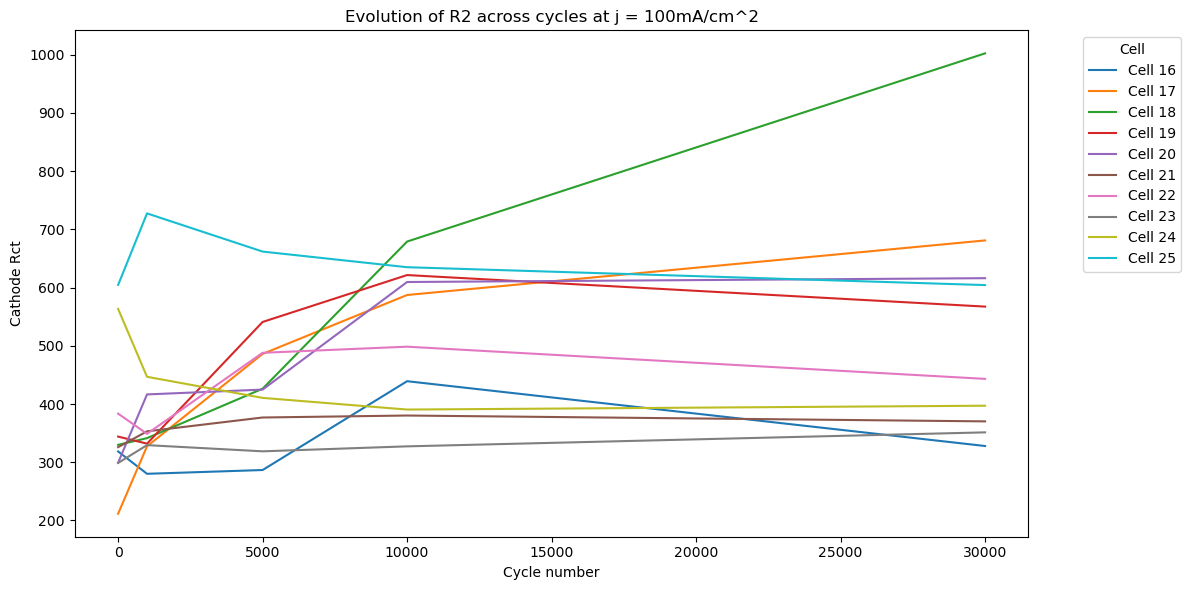

In [241]:
plot_R2(input_df,16,25,100)

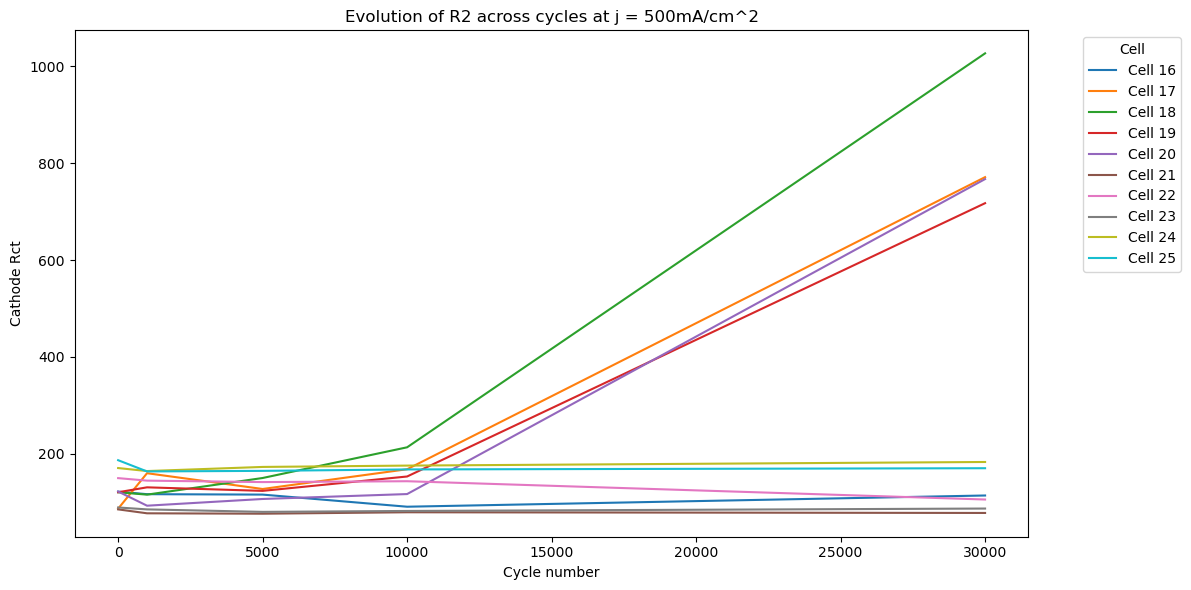

In [242]:
plot_R2(input_df,16,25,500)

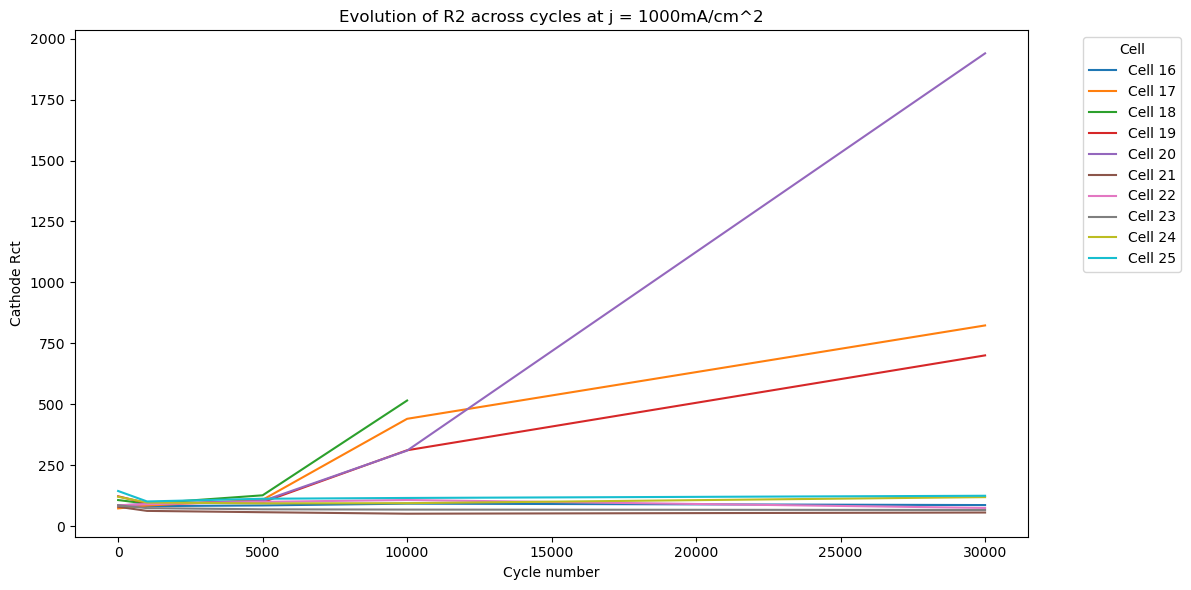

In [243]:
plot_R2(input_df,16,25,1000)

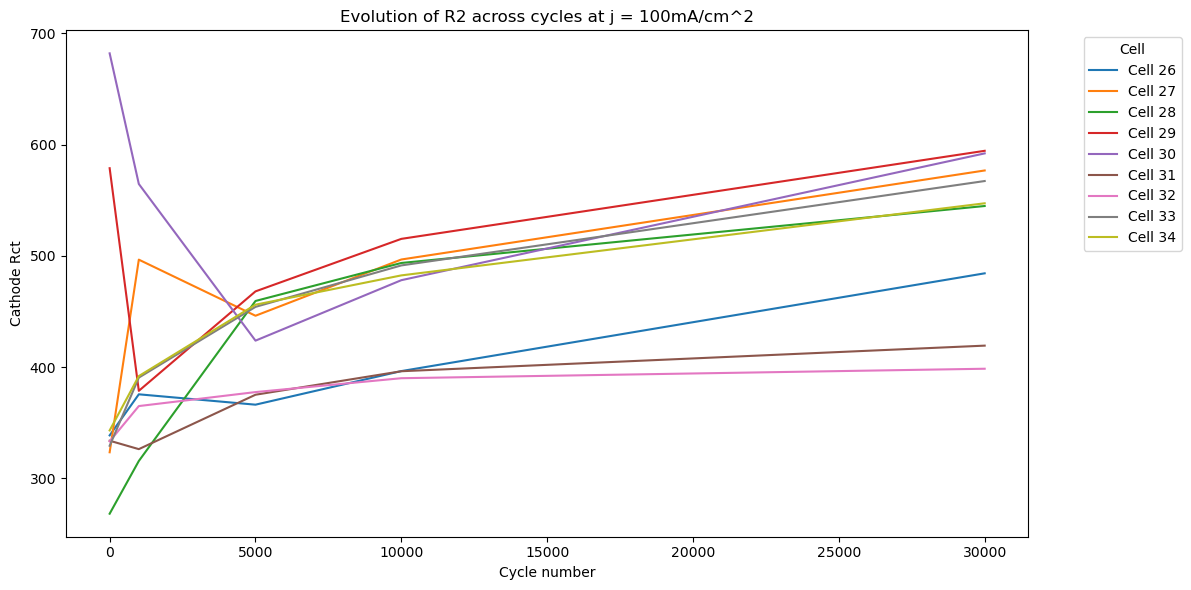

In [244]:
plot_R2(input_df,26,36,100)

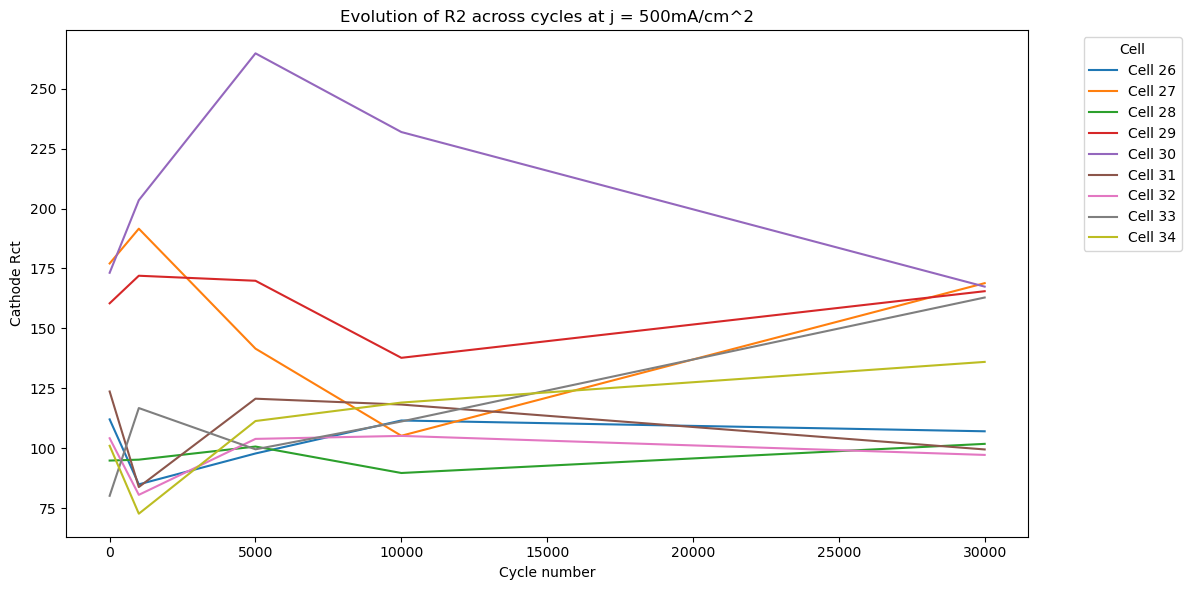

In [245]:
plot_R2(input_df,26,36,500)

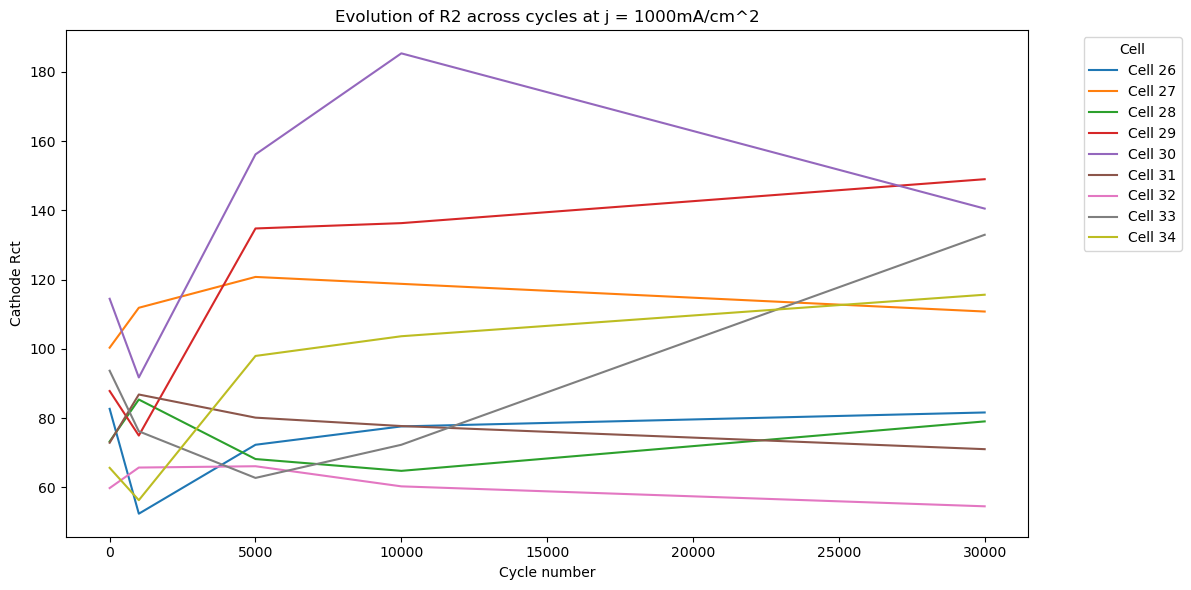

In [246]:
plot_R2(input_df,26,36,1000)

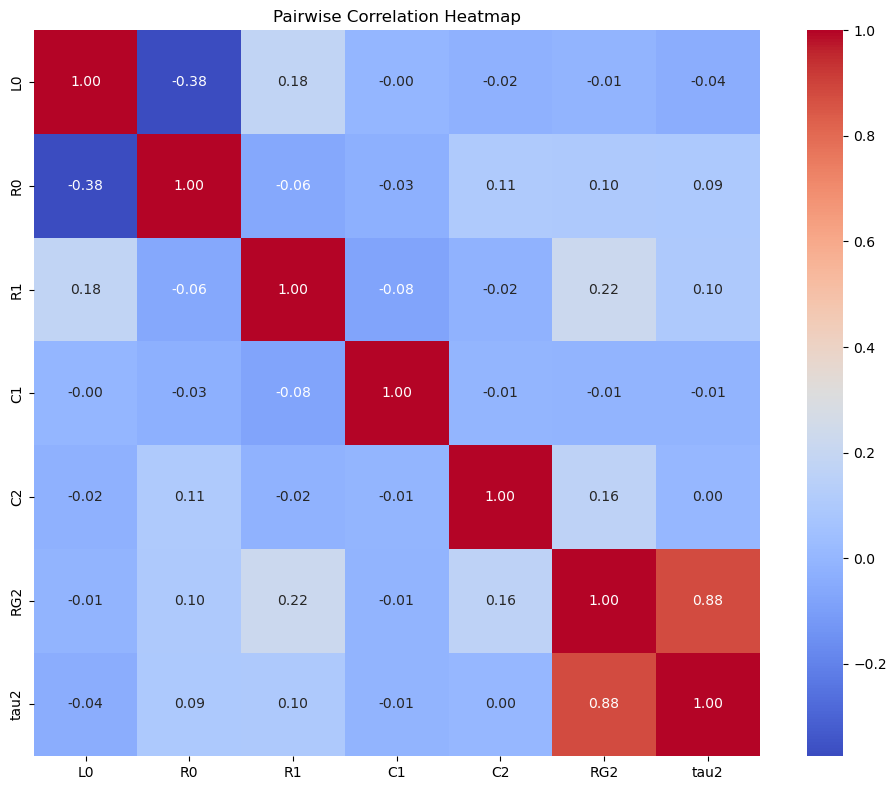

In [247]:
X_df = input_df[['L0', 'R0', 'R1', 'C1', 'C2', 'RG2', 'tau2']]
plt.figure(figsize=(10, 8))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pairwise Correlation Heatmap')
plt.tight_layout()
plt.show()

### Elimination of features
We observe that the **highest correlation** occurs between the columns of **L0** and **R0** as well as the columns **RG2** and **tau2**. The other columns do not show any significant correlations with each other and so we need to pass it forward to the final regression model

In [248]:
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

vif_df = compute_vif(X_df)
print('\nVIF values:')
print(vif_df)


VIF values:
  Feature        VIF
0      L0  14.637430
1      R0  12.570991
2      R1   3.212923
3      C1   1.296400
4      C2   1.158494
5     RG2   5.726437
6    tau2   5.206004


In [249]:
X_input_1 = X_df.drop(columns=['L0']) #removing the series inductance with largest VIF value

In [250]:
iterated_vif = compute_vif(X_input_1)
print(iterated_vif)

  Feature       VIF
0      R0  2.843793
1      R1  2.789213
2      C1  1.273457
3      C2  1.156639
4     RG2  5.713306
5    tau2  5.205918


In [251]:
X_input_2 = X_input_1.drop(columns='tau2') #removing the tau2 parameter for the Nernst element as we want to deal with resistances

In [252]:
iterated_vif = compute_vif(X_input_2)

### Confirmation with VIF
We confirmed the presence of extensive **multicollinearity** between the features of L0 and R0. We then ran a ranking algorithm to recursively remove all features displaying a VIF greater than 5.0 (standard considerations). This lead us to drop the feature of L0 and tau2 with the highest VIF. All other VIF values are within the **acceptable range**.

In [253]:
print("Final VIF:\n",iterated_vif)

Final VIF:
   Feature       VIF
0      R0  2.823748
1      R1  2.609157
2      C1  1.272714
3      C2  1.038216
4     RG2  1.109641


In [254]:
input_df.drop(columns = ['L0','tau2'], axis = 1, inplace = True) #dropping the columns identified
print(input_df.head())

   Cell    Cycle         R0          R1        C1        C2         RG2  \
0   1.0      0.0  19.362419  201.942405  0.000055  0.000008  118.076624   
1   1.0  10000.0  16.088107  202.877711  0.000047  0.000014  341.789274   
2   1.0   1000.0  15.876152  187.366520  0.000055  0.000013  328.006978   
3   1.0  30000.0  16.620932  216.056498  0.000041  0.000015  346.707058   
4   1.0   5000.0  16.256376  209.817899  0.000047  0.000014  340.810988   

   Current          R2  
0    100.0  211.234409  
1    100.0  236.149723  
2    100.0  240.484146  
3    100.0  226.995199  
4    100.0  222.781515  


In [ ]:
#add list of variable names

### Outlier detection
Although not expected, we should check for the presence of any outliers in the features to ensure that the input data does not get skewed due to the presence of a large single peak. This is achieved by observing the **boxplots** for each column.

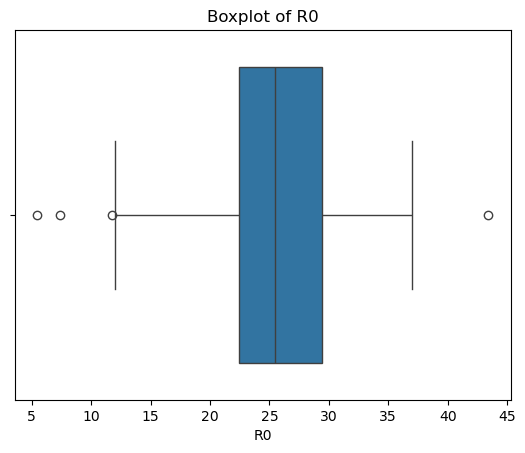

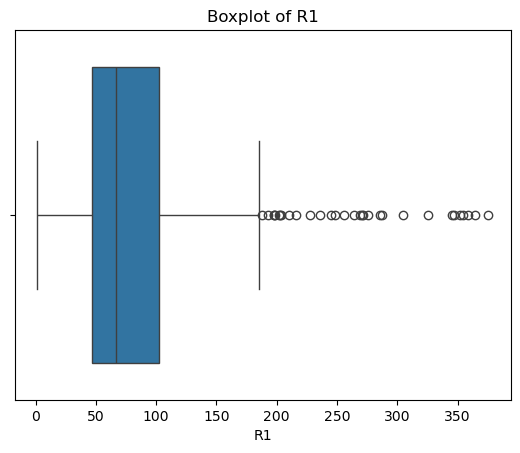

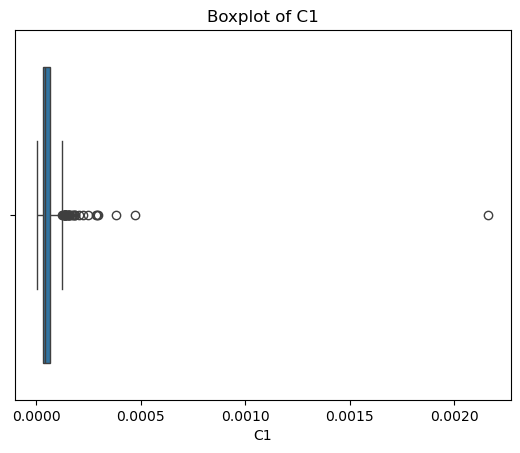

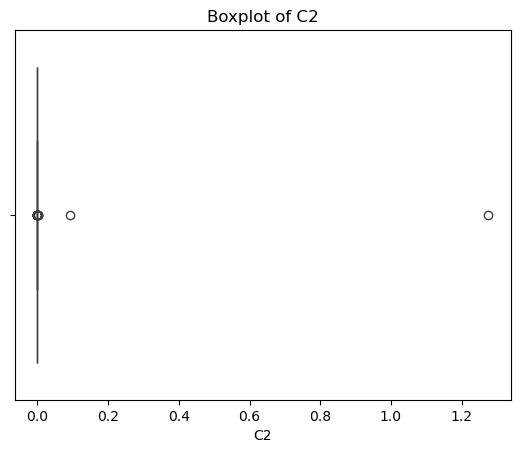

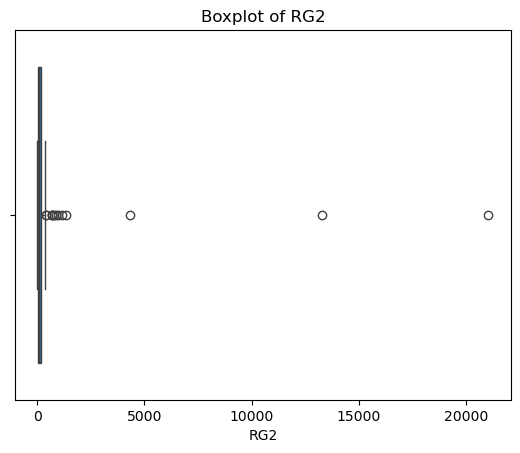

In [257]:
for col in X_input_2.columns:
    plt.figure()
    sns.boxplot(x=X_input_2[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### Checking model fits
The presence of some outliers is a bit concerning. Let us eliminate models which have a very bad fit with this ECM and see if the outliers are valid or not. Based on the top 1% worst values, we can check which cells have such a bad fit and see if we can eliminate or replace them.

In [258]:
mape_list = np.array(mape)  
threshold = np.percentile(mape_list, 99)

# Get indexes of values above the 99th percentile (worst 1%)
worst_indexes = np.where(mape_list >= threshold)[0]

for idx in worst_indexes:
    print(f"Index: {idx}, MAPE: {mape_list[idx]:.2f}%")

Index: 19, MAPE: 9.06%
Index: 171, MAPE: 6.15%
Index: 192, MAPE: 6.05%
Index: 341, MAPE: 6.31%
Index: 346, MAPE: 4.52%


### Distribution of input variables
We should try to keep the input variables normally distributed to ensure that the model trains well on the data range that we have instead of having a preference to a particular skewed side. 

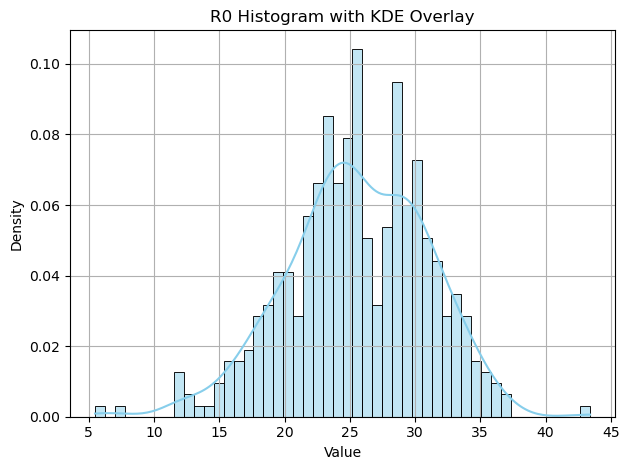

In [262]:
sns.histplot(input_df['R0'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('R0 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


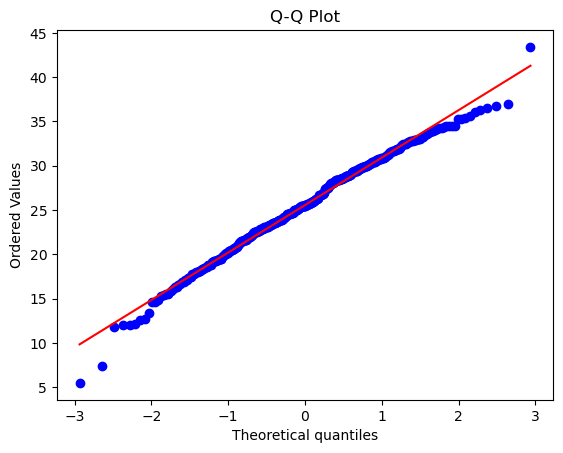

In [263]:
stats.probplot(input_df['R0'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Notes on R0
The data of R0 is approximately normally distributed without any obvious outliers. We do not need to further process this.

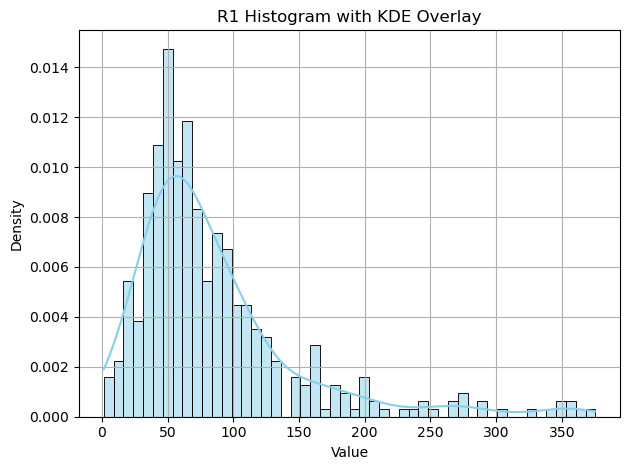

In [264]:
sns.histplot(input_df['R1'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('R1 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


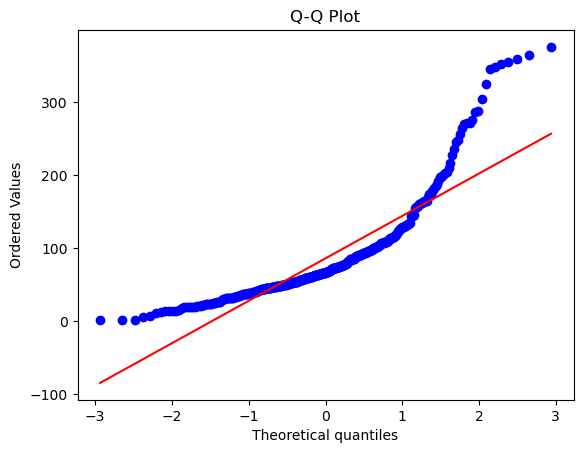

In [265]:
stats.probplot(input_df['R1'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Notes on R1
The data of R1 is heavily skewed to the left with some outliers to the right. Due to limited size of the dataset, we should remove them to avoid skewing of the model. It is also physically expected that there should not be orders of magnitude difference between the R1 values of different cells.

In [266]:
#define the interquartile range to remove outliers based on the values of column R1
Q1 = input_df['R1'].quantile(0.25)
Q3 = input_df['R1'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Impute rows where 'R1' is an outlier
input_df['R1'] = input_df['R1'].apply(lambda x:Q1 if x<lower_bound else Q3 if x>upper_bound else x)


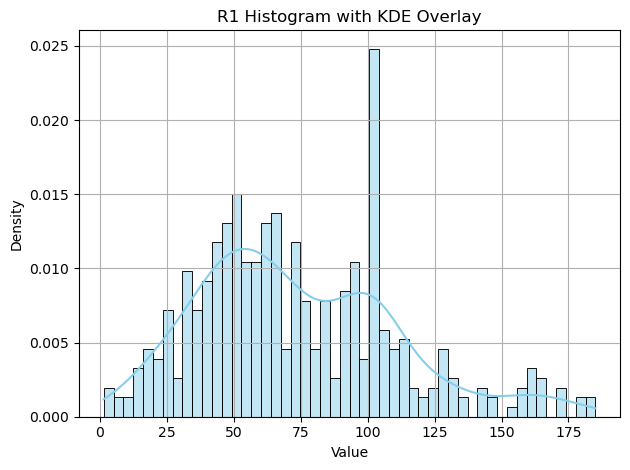

In [267]:
sns.histplot(input_df['R1'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('R1 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


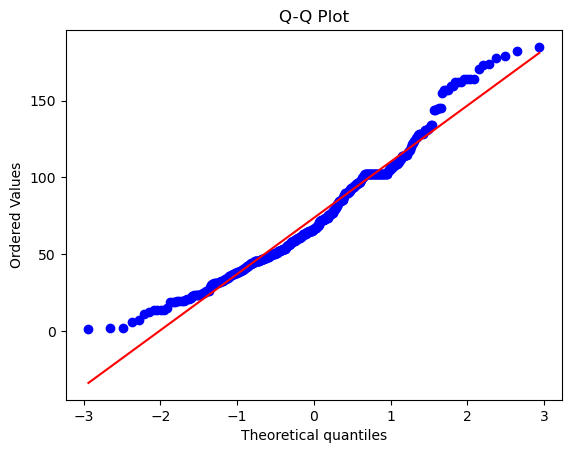

In [269]:
stats.probplot(input_df['R1'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Cleaned column R1
Although the QQ plot is not close to that of a normal distribution, due to the tree based nature of XGBoost, we do not require power scaling methods like the **Box-Cox transform**.

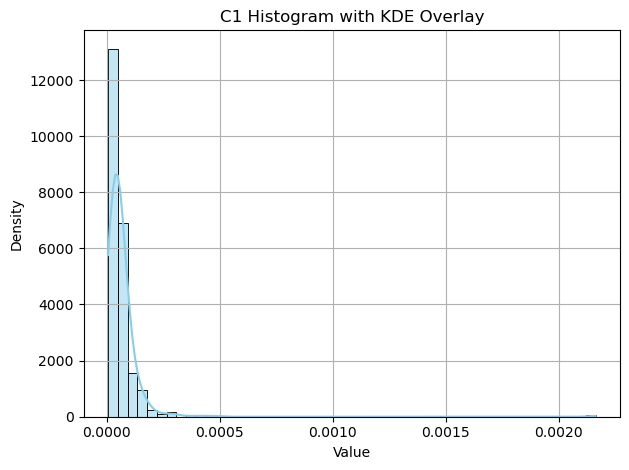

In [273]:
sns.histplot(input_df['C1'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('C1 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


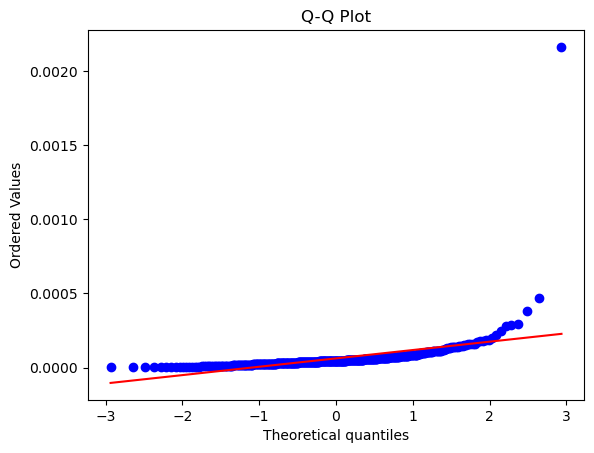

In [274]:
stats.probplot(input_df['C1'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Notes on C1
Due to the presence of a few outliers, the output gets distorted. We must again impute the outliers to ensure that the fit is good.

In [275]:
#define the interquartile range to remove outliers based on the values of column R1
Q1 = input_df['C1'].quantile(0.25)
Q3 = input_df['C1'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#impute rows where C1 is an outlier
input_df['C1'] = input_df['C1'].apply(lambda x:Q1 if x<lower_bound else Q3 if x>upper_bound else x)


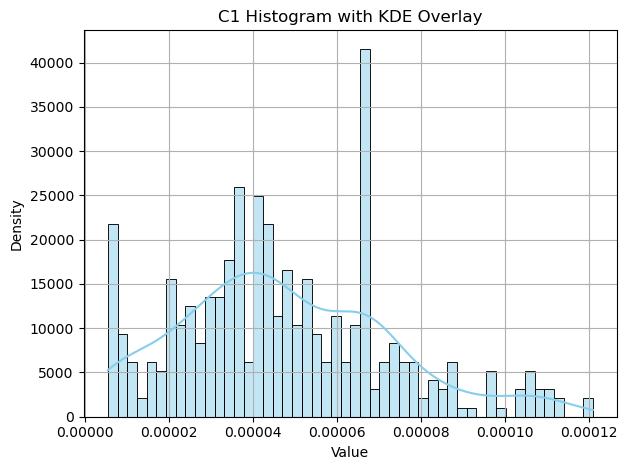

In [276]:
sns.histplot(input_df['C1'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('C1 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


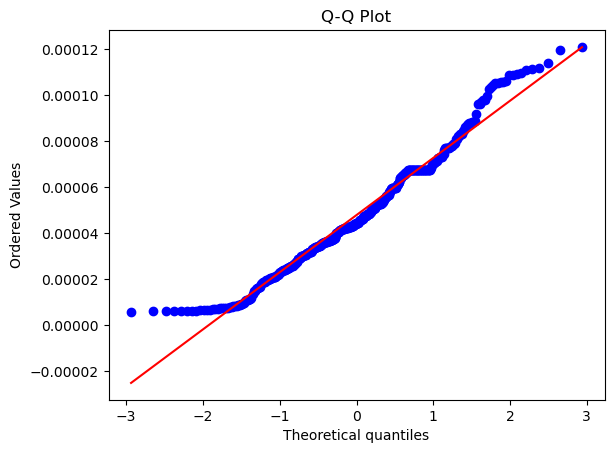

In [277]:
stats.probplot(input_df['C1'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Cleaned column C1
Removing the outliers has given us an approximately normal distribution for the column C1.

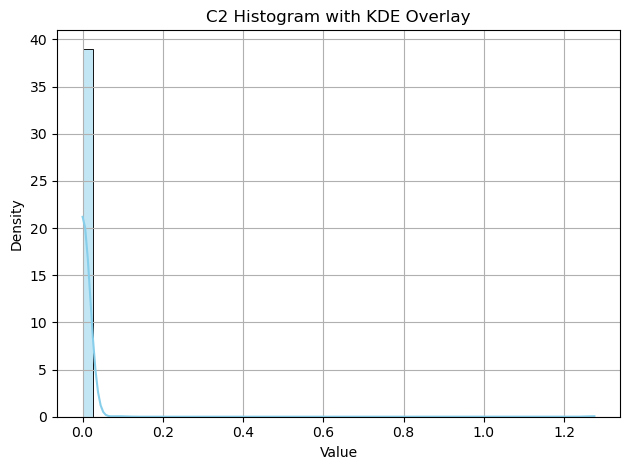

In [278]:
sns.histplot(input_df['C2'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('C2 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


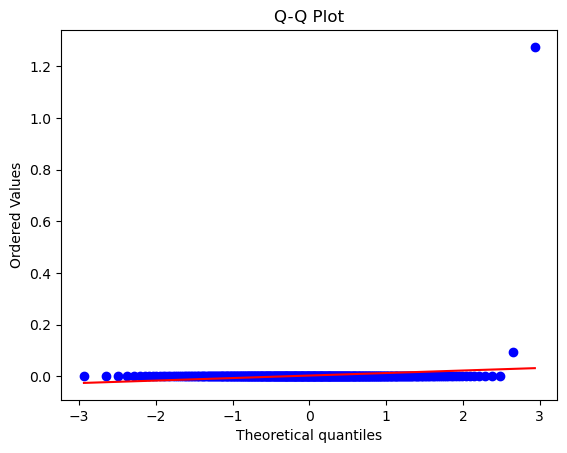

In [279]:
stats.probplot(input_df['C2'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Notes on C2
As before, the presence of a single outlier is distorting the data that we have. It would help the model by imputing this outlier.

In [280]:
#define the interquartile range to remove outliers based on the values of column R1
Q1 = input_df['C2'].quantile(0.25)
Q3 = input_df['C2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#impute rows where C2 is an outlier
input_df['C2'] = input_df['C2'].apply(lambda x:Q1 if x<lower_bound else Q3 if x>upper_bound else x)


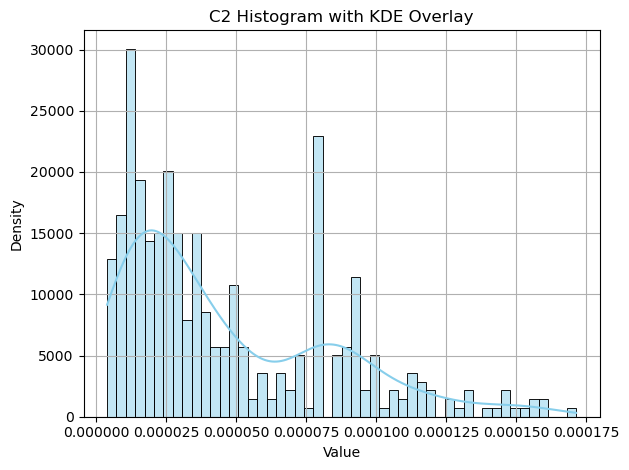

In [281]:
sns.histplot(input_df['C2'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('C2 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


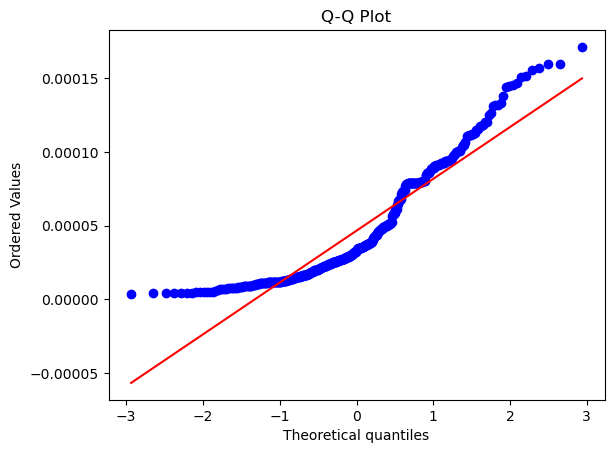

In [282]:
stats.probplot(input_df['C2'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

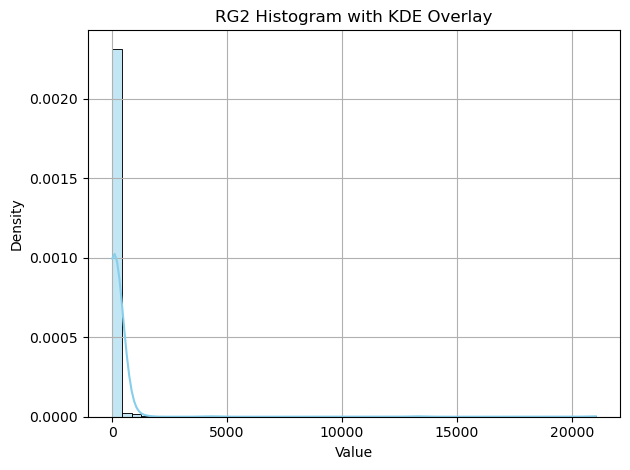

In [283]:
sns.histplot(input_df['RG2'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('RG2 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


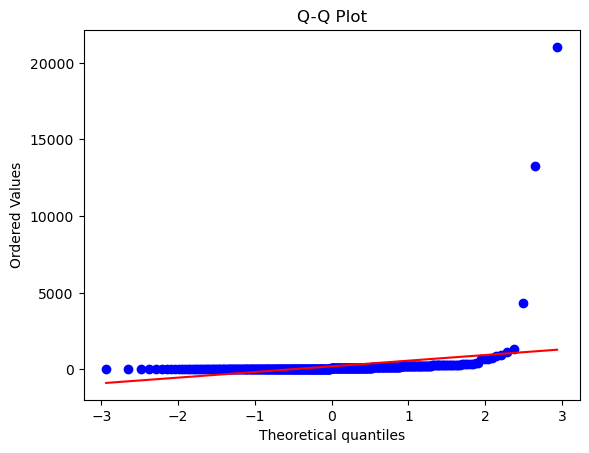

In [284]:
stats.probplot(input_df['RG2'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Notes on RG2
RG2 also requires outlier elimination for proper model fitting.

In [285]:
#define the interquartile range to remove outliers based on the values of column R1
Q1 = input_df['RG2'].quantile(0.25)
Q3 = input_df['RG2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#impute rows where RG2 is an outlier
input_df['RG2'] = input_df['RG2'].apply(lambda x:Q1 if x<lower_bound else Q3 if x>upper_bound else x)


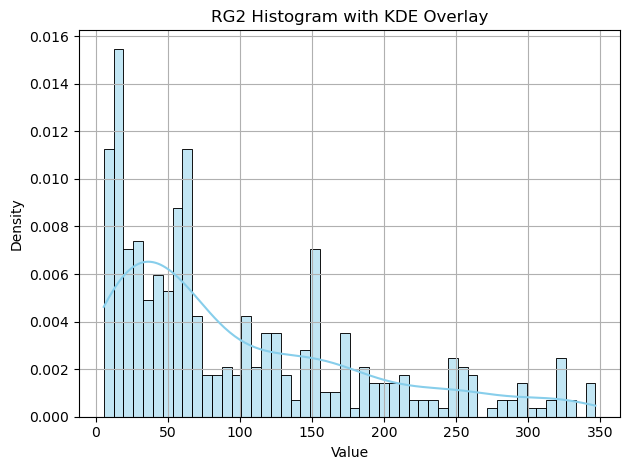

In [286]:
sns.histplot(input_df['RG2'].dropna(), kde=True, bins=50, stat='density', color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('RG2 Histogram with KDE Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


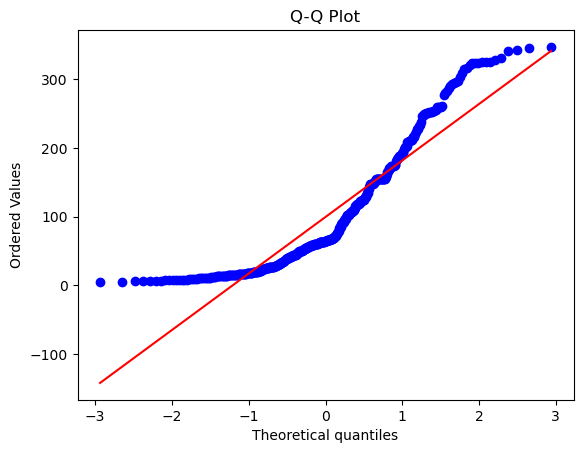

In [287]:
stats.probplot(input_df['RG2'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Final cleaned dataframe
After cleaning up the outliers which would have skewed the dataset, let us look at the final result. There is very less skewing in the features now. This will lead to a more robust model.

In [288]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

features = ['L0', 'R0', 'R1', 'C1', 'C2', 'tau2']
X_scaled = StandardScaler().fit_transform(X_cleaned4)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='pca')
X_embedded = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
print(tsne_df.head())


        Dim1       Dim2
0   3.035238 -10.585281
1  21.171125  -6.747891
2  21.729094  -7.009469
3  20.185184  -6.252682
4  21.559772  -6.840527


C:\Users\Biswadeep\AppData\Local\Temp\ipykernel_10028\1189787224.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', alpha=0.7, palette = 'viridis')


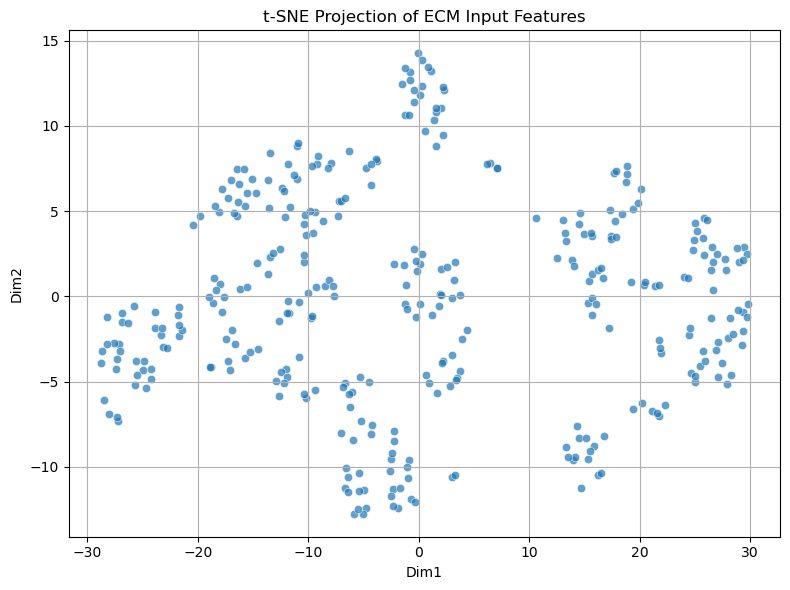

In [289]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', alpha=0.7, palette = 'viridis')
plt.title('t-SNE Projection of ECM Input Features')
plt.grid(True)
plt.tight_layout()
plt.show()


### Notes on the tSNE
Lower dimensional visualization of the input features shows the definite possibility of clusters occurring among the cells. Further exploration and clustering algorithms will be required to accurately pinpoint the reason behind the clusters.

In [290]:
cathode_df = pd.read_excel('CathodeData.xlsx')
print(cathode_df.head())

   Cell  Pt load  I/C ratio  Io EW  Pt/C ratio  Pt(SUP1)  Pt(SUP2)  \
0     1   0.3839        0.5    790          50         1         0   
1     2   0.3793        0.8    790          50         1         0   
2     3   0.3810        1.2    790          50         1         0   
3    10   0.3863        0.5    790          50         1         0   
4    11   0.3816        0.8    790          50         1         0   

   PtCo(SUP1)   UPL  
0           0  0.95  
1           0  0.95  
2           0  0.95  
3           0  1.15  
4           0  1.15  


In [294]:
## merging the input features together 
X_merged = input_df.merge(cathode_df, on = 'Cell', how = 'left')
print(X_merged.head())

   Cell    Cycle         R0          R1        C1        C2         RG2  \
0   1.0      0.0  19.362419  102.033841  0.000055  0.000008  118.076624   
1   1.0  10000.0  16.088107  102.033841  0.000047  0.000014  341.789274   
2   1.0   1000.0  15.876152  102.033841  0.000055  0.000013  328.006978   
3   1.0  30000.0  16.620932  102.033841  0.000041  0.000015  346.707058   
4   1.0   5000.0  16.256376  102.033841  0.000047  0.000014  340.810988   

   Current          R2  Pt load  I/C ratio  Io EW  Pt/C ratio  Pt(SUP1)  \
0    100.0  211.234409   0.3839        0.5    790          50         1   
1    100.0  236.149723   0.3839        0.5    790          50         1   
2    100.0  240.484146   0.3839        0.5    790          50         1   
3    100.0  226.995199   0.3839        0.5    790          50         1   
4    100.0  222.781515   0.3839        0.5    790          50         1   

   Pt(SUP2)  PtCo(SUP1)   UPL  
0         0           0  0.95  
1         0           0  0.95  
2 

In [ ]:
IV_data = 

In [131]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [132]:
###preprocessing to scale the input data (except the one hot encodings)
df = X_merged.copy()
one_hot_cols = ['Current', 'Cycle', 'Pt/C ratio', 'I/C ratio', 'UPL', 'Cell','Pt(SUP1)','Pt(SUP2)','PtCo(SUP1)']
num_cols = [col for col in df.columns if col not in one_hot_cols]

# scaling only on numerical columns
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(df[num_cols])
scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols, index=df.index)


# combine them back
model_input = pd.concat([scaled_num_df, df[one_hot_cols]], axis=1)
print(model_input.head())


         L0        R1        C1        C2      tau2        R2   Pt load  \
0  0.347089  0.275701  0.414973  0.025550  0.110460  0.312611  0.474797   
1  0.420922  0.277015  0.354568  0.062447  0.513485  0.353029  0.474797   
2  0.434952  0.255222  0.420975  0.051845  0.617173  0.360060  0.474797   
3  0.418614  0.310900  0.297955  0.064561  0.472047  0.320434  0.474797   
4  0.431728  0.286766  0.352212  0.057999  0.564059  0.331343  0.474797   

      Io EW  Current    Cycle  Pt/C ratio  I/C ratio   UPL  Cell  Pt(SUP1)  \
0  0.269231    100.0      0.0          50        0.5  0.95   1.0         1   
1  0.269231    100.0  10000.0          50        0.5  0.95   1.0         1   
2  0.269231    100.0   1000.0          50        0.5  0.95   1.0         1   
3  0.269231    100.0  30000.0          50        0.5  0.95   1.0         1   
4  0.269231    100.0   5000.0          50        0.5  0.95   1.0         1   

   Pt(SUP2)  PtCo(SUP1)  
0         0           0  
1         0           0  
2 

In [45]:
print(model_input.shape)

(347, 16)


In [46]:
#train the XGBoost algorithm on this
X_boost = model_input.drop(columns=['R2'])
y_boost = model_input['R2'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_boost, y_boost, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

#perform 5 fold cross validation of the dataset
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_boost, y_boost, cv=cv, scoring='r2')
print(f'Average R² score (5-fold CV): {cv_scores.mean():.4f}')

Average R² score (5-fold CV): 0.7838


In [47]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

#analyze model metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")


Test R²: 0.6633
Test MAE: 0.0372
Test RMSE: 0.0815


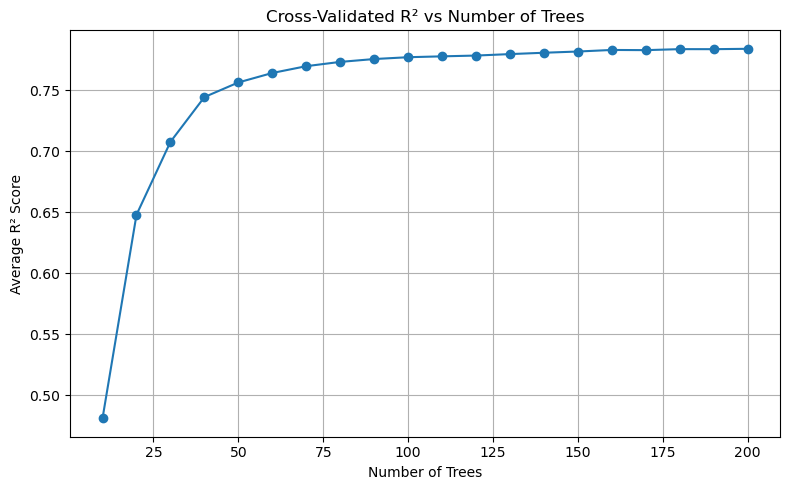

In [48]:
results = []
for n_trees in range(10, 201, 10):
    model = xgb.XGBRegressor(n_estimators=n_trees, max_depth=4,
                             learning_rate=0.1, objective='reg:squarederror',
                             random_state=42)
    score = cross_val_score(model, X_boost, y_boost, cv=cv, scoring='r2').mean()
    results.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(10, 201, 10), results, marker='o')
plt.title('Cross-Validated R² vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Average R² Score')
plt.grid(True)
plt.tight_layout()
plt.show()

### Notes on fit
The cross validated R^2 score reaches close to **0.78**, which implies a good fit on the given data. We also observed that the model performs fairly well on the given dataset, with an around **4%** MAPE error and a 0.66 R^2 value on the test set. We also observe a plateauing effect of the cross validated R^2 metric at around 200 trees, meaning that we do not need to increase the number of trees any further to ensure a better fit.

## Clustering Algorithms
After performing regression using the XGBoosted tree, we can try out clustering on the sample data. The tSNE data reveals 8 distinct clusters from a preliminary glance. We could also try and use the DBSCAN clustering algorithm to check for any other physical interpretations.

### KMeans
We will try to find the optimal number of clusters of KMeans using the elbow method and silhoutte score.

C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

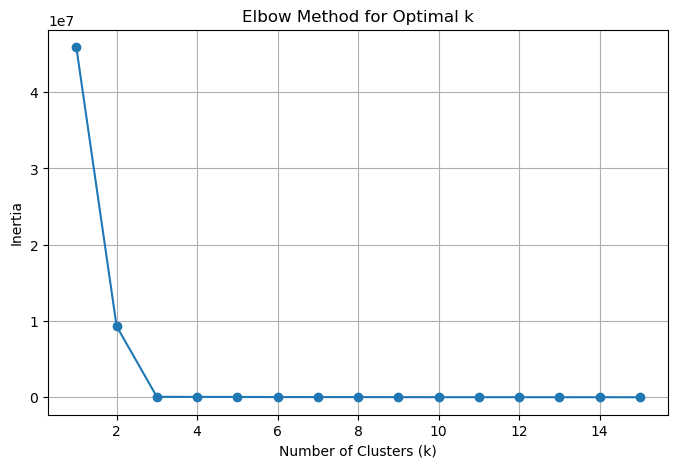

In [49]:
inertia = []
k_range = range(1, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_boost)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [ ]:
#include descriptions of the metrics used

C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

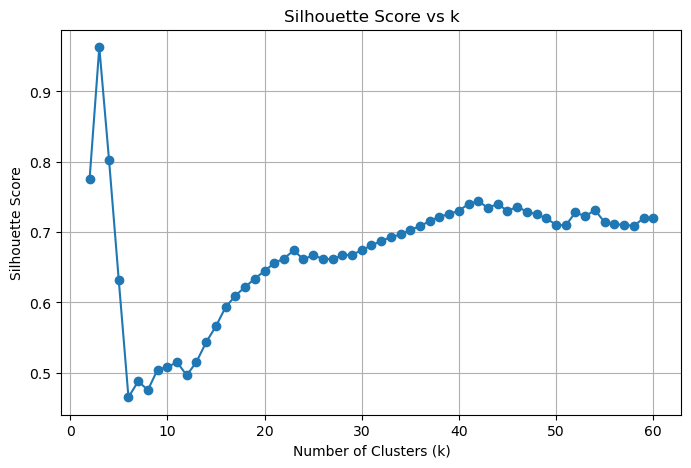

In [50]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 61):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_boost)
    score = silhouette_score(X_boost, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 61), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.grid(True)
plt.show()

### Optimal value of K
Based on the silhoutte scores and the elbow method, we could argue that the best clustering occurs at **k = 3**. 

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
k_labels = kmeans.fit_predict(X_boost)
df['KMeans Cluster'] = k_labels

C:\Users\Biswadeep\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [52]:
print("KMeans Clusters:\n", df.groupby('KMeans Cluster')['R2'].describe(), "\n")

KMeans Clusters:
                 count        mean         std        min        25%  \
KMeans Cluster                                                        
0               122.0  102.943817   41.078576  18.527478  73.517004   
1               115.0   82.714370   35.712450  31.481622  62.712715   
2               110.0  166.533784  127.196970  41.499516  91.541356   

                       50%         75%         max  
KMeans Cluster                                      
0                99.612781  128.798957  203.465453  
1                77.715248   94.550320  345.491458  
2               122.015706  177.046899  634.970462   



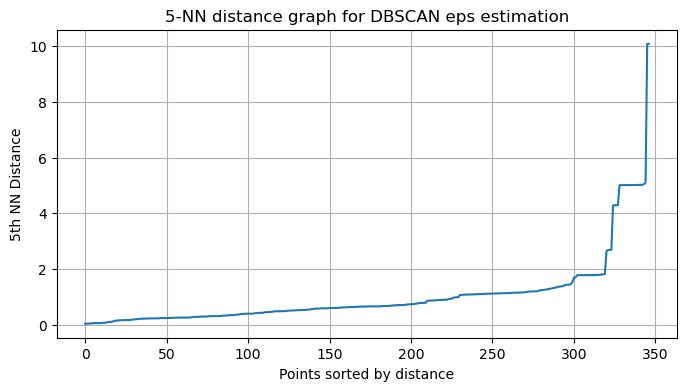

In [53]:
from sklearn.neighbors import NearestNeighbors

k = 5  # Choose min_samples
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_boost)  
distances, indices = nbrs.kneighbors(X_boost)

# Sort and plot k-distances
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f"{k}-NN distance graph for DBSCAN eps estimation")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th NN Distance")
plt.grid()
plt.show()


In [54]:
dbscan = DBSCAN(eps=350, min_samples=5)
d_labels = dbscan.fit_predict(X_boost)
df['DBSCAN Cluster'] = d_labels

In [55]:
print("DBSCAN Clusters:\n", df.groupby('DBSCAN Cluster')['R2'].describe())

DBSCAN Clusters:
                 count        mean         std        min        25%  \
DBSCAN Cluster                                                        
0               110.0  166.533784  127.196970  41.499516  91.541356   
1               122.0  102.943817   41.078576  18.527478  73.517004   
2               115.0   82.714370   35.712450  31.481622  62.712715   

                       50%         75%         max  
DBSCAN Cluster                                      
0               122.015706  177.046899  634.970462  
1                99.612781  128.798957  203.465453  
2                77.715248   94.550320  345.491458  


In [56]:
n_clusters = len(set(d_labels)) - (1 if -1 in d_labels else 0)
n_noise = list(d_labels).count(-1)

if n_clusters > 1:
    sil_score = silhouette_score(X_boost, d_labels)
else:
    sil_score = None

print(f"Estimated clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({n_noise / len(d_labels):.2%})")
if sil_score:
    print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("Silhouette Score not meaningful (only 1 cluster detected).")

Estimated clusters: 3
Noise points: 0 (0.00%)
Silhouette Score: 0.963


### Optimal DBSCAN parameters
We once again end up with **3 main** clusters using the knee method and silhouette scores on the DBSCAN algorithm. This validates our previous approach using the KMeans method.

### Physical interpretation
I have tabulated the std deviation, mean and quantiles for the R2 column for each cluster. This could give us an idea about the differentiating feature of each row in the input label based on the changing value of the charge transfer resistance R2 at the cathode. This could give us an idea into how exactly we predict how much "degradation" a fuel cell has undergone.

In [57]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_boost)



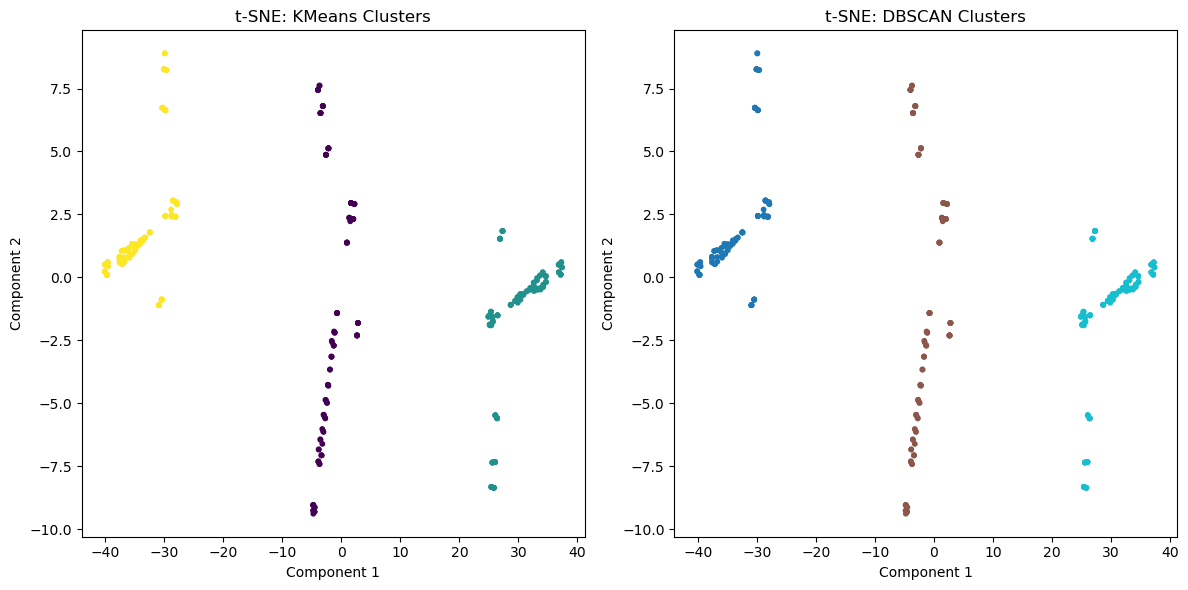

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=k_labels, cmap='viridis', s=10)
plt.title("t-SNE: KMeans Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=d_labels, cmap='tab10', s=10)
plt.title("t-SNE: DBSCAN Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.tight_layout()
plt.show()

### Notes on clustering
Based on the lower dimensional projection of the data, both the algorithms are performing a good job of picking out distinct clusters in the original data. We need to further investigate how the characteristics of each cluster is physically explainable.

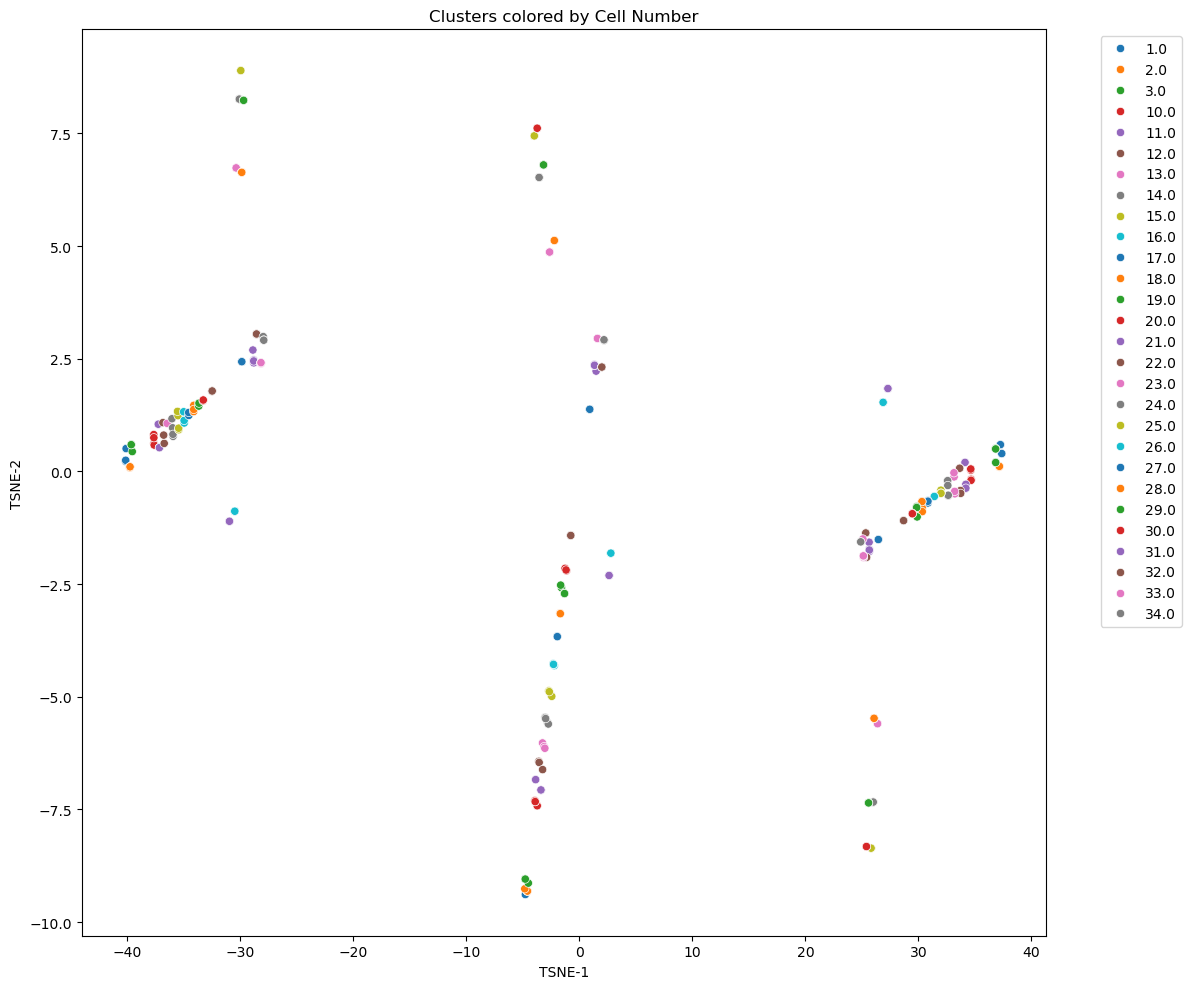

In [59]:
features = X_boost.drop(columns=['Cell'])  # keep only feature columns
labels = X_boost['Cell']  # for coloring

# Create a plot dataframe
tsne_df = pd.DataFrame({
    'TSNE-1': X_embedded[:, 0],
    'TSNE-2': X_embedded[:, 1],
    'Cell': labels
})

# Plot with color
plt.figure(figsize=(12, 10))
sns.scatterplot(data=tsne_df, x='TSNE-1', y='TSNE-2', hue='Cell', palette='tab10', legend='full')
plt.title('Clusters colored by Cell Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [60]:
X_cluster = X_boost.copy()
X_cluster['cluster'] = k_labels

X_input = X_cluster.drop(columns=['Cell','cluster'])
y_target = X_cluster['cluster']

In [61]:
print(X_input.head())

         L0        R1        C1        C2      tau2   Pt load     Io EW  \
0  0.347089  0.275701  0.414973  0.025550  0.110460  0.474797  0.269231   
1  0.420922  0.277015  0.354568  0.062447  0.513485  0.474797  0.269231   
2  0.434952  0.255222  0.420975  0.051845  0.617173  0.474797  0.269231   
3  0.418614  0.310900  0.297955  0.064561  0.472047  0.474797  0.269231   
4  0.431728  0.286766  0.352212  0.057999  0.564059  0.474797  0.269231   

   Current  Pt/C ratio  I/C ratio   UPL  Pt(SUP1)  Pt(SUP2)  PtCo(SUP1)  
0    100.0          50        0.5  0.95         1         0           0  
1    100.0          50        0.5  0.95         1         0           0  
2    100.0          50        0.5  0.95         1         0           0  
3    100.0          50        0.5  0.95         1         0           0  
4    100.0          50        0.5  0.95         1         0           0  


In [62]:
print(y_target.head())

0    2
1    2
2    2
3    2
4    2
Name: cluster, dtype: int32


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [64]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf_final = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth': [2, 3, 5],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50]
}
cv_outer = StratifiedKFold(5, shuffle=True, random_state=42)
grid = GridSearchCV(rf_final, param_grid, cv=cv_outer, scoring='accuracy')
grid.fit(X_cluster, y_target)
print("Best params:", grid.best_params_)

Best params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


C:\Users\Biswadeep\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [65]:
tree_range = range(10, 201, 10)
rf_scores = []

for n_trees in tree_range:
    rf = rf = RandomForestClassifier(
    n_estimators=n_trees,
    max_depth=2,             # shallower trees
    min_samples_split=2,    # fewer splits
    min_samples_leaf=1,      # leaf size
    max_features='sqrt',     # features per split
    bootstrap=True,
    random_state=42
    )
    scores = cross_val_score(rf, X_cluster, y_target, cv=5, scoring='accuracy')  # Use accuracy for multiclass
    mean_score = np.mean(scores)
    rf_scores.append(mean_score)
    print(f"Trees: {n_trees} | CV Accuracy: {mean_score:.4f}")


Trees: 10 | CV Accuracy: 1.0000
Trees: 20 | CV Accuracy: 1.0000
Trees: 30 | CV Accuracy: 1.0000
Trees: 40 | CV Accuracy: 1.0000
Trees: 50 | CV Accuracy: 1.0000
Trees: 60 | CV Accuracy: 1.0000
Trees: 70 | CV Accuracy: 1.0000
Trees: 80 | CV Accuracy: 1.0000
Trees: 90 | CV Accuracy: 1.0000
Trees: 100 | CV Accuracy: 1.0000
Trees: 110 | CV Accuracy: 1.0000
Trees: 120 | CV Accuracy: 1.0000
Trees: 130 | CV Accuracy: 1.0000
Trees: 140 | CV Accuracy: 1.0000
Trees: 150 | CV Accuracy: 1.0000
Trees: 160 | CV Accuracy: 1.0000
Trees: 170 | CV Accuracy: 1.0000
Trees: 180 | CV Accuracy: 1.0000
Trees: 190 | CV Accuracy: 1.0000
Trees: 200 | CV Accuracy: 1.0000


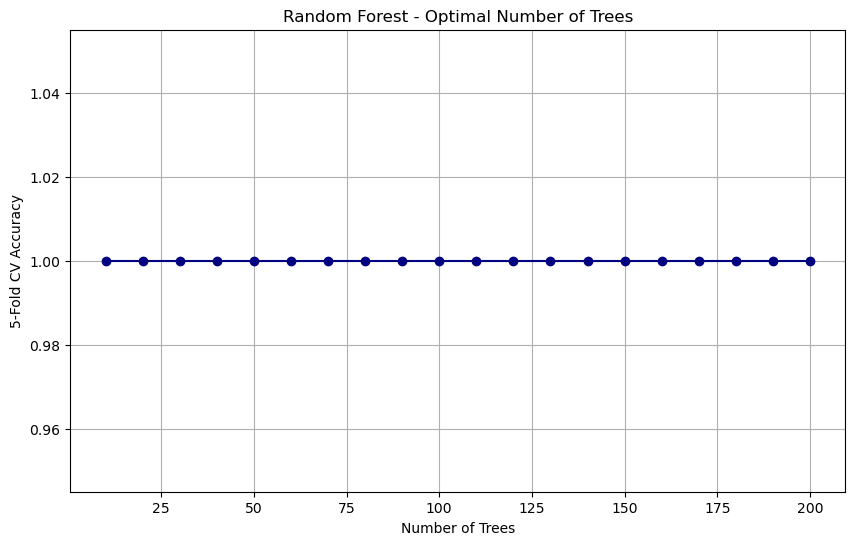

Optimal number of trees: 10


In [66]:
plt.figure(figsize=(10, 6))
plt.plot(tree_range, rf_scores, marker='o', color='navy')
plt.xlabel("Number of Trees")
plt.ylabel("5-Fold CV Accuracy")
plt.title("Random Forest - Optimal Number of Trees")
plt.grid(True)
plt.show()

# Best n_trees
best_n = tree_range[np.argmax(rf_scores)]
print(f"Optimal number of trees: {best_n}")

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_target, test_size=0.2, stratify=y_target, random_state=42)

# Train model

rf_final.fit(X_train, y_train)

# Predict
y_pred = rf_final.predict(X_test)
y_proba = rf_final.predict_proba(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        22

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



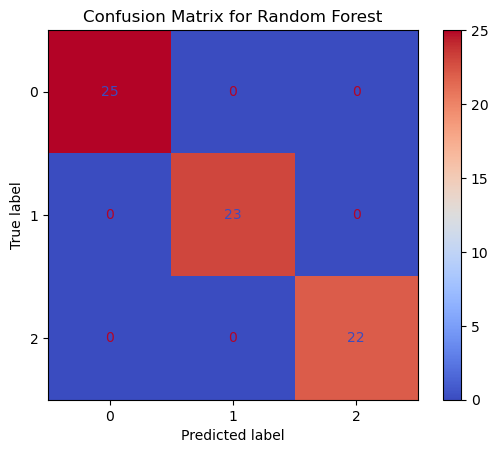

Multiclass AUC (OvR macro): 1.0000


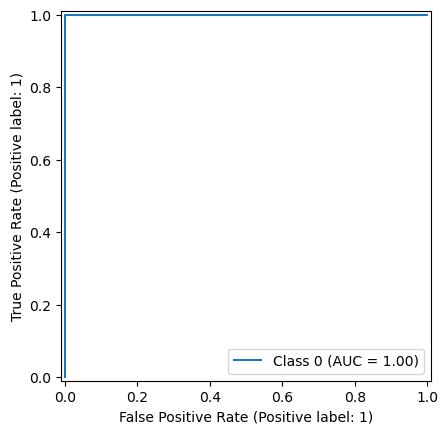

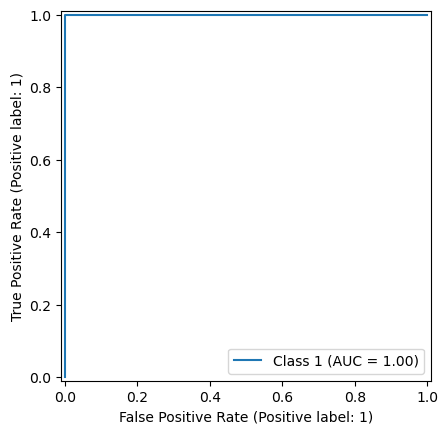

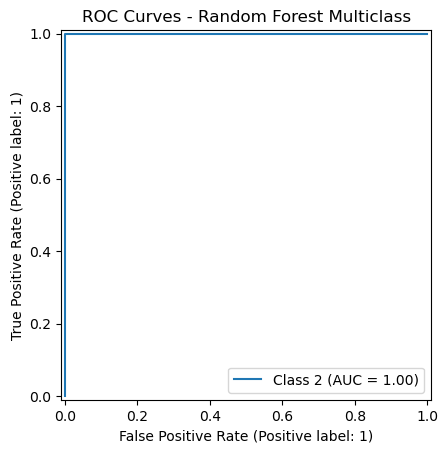

In [69]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="coolwarm")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# AUC (Multiclass using One-vs-Rest)
classes = np.unique(y_target)
y_test_binarized = label_binarize(y_test, classes=classes)
rf_auc = roc_auc_score(y_test_binarized, y_proba, average="macro", multi_class="ovr")
print(f"Multiclass AUC (OvR macro): {rf_auc:.4f}")

# ROC Curves
for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(y_test_binarized[:, i], y_proba[:, i], name=f"Class {cls}")

plt.title("ROC Curves - Random Forest Multiclass")
plt.show()

### Optimal Number of Decision Trees
Based on cross-validated scores, we observe that the best accuracies come at a classification of **10** trees. The CV accuracy is close to **100%**.

In [133]:
#reference to using peaks of DRT for splitting of the diameter of the Nyquist plot

### Optimal number of Trees
For the XGBoosted Classifier, we get the optimal number of trees at around **10**. 